<a href="https://colab.research.google.com/github/mileskarr/Final-Project/blob/main/Draft_Code_for_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#Imports
import pandas as pd
import numpy as np
import os
import glob
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import random
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from collections import Counter
import collections


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/drive


In [4]:
#To combine multiple files containing reviews into one.
folder_path = '/content/drive/MyDrive/CIND820/Data/Reviews'
all_reviews = os.listdir(folder_path)
csv_files = [f for f in all_reviews if f.endswith('.csv')]
df_list = []

In [5]:
#To combine multiple files containing reviews into one.
for csv in csv_files:
    file_path = os.path.join(folder_path, csv)
    try:
      df = pd.read_csv(file_path)
      df_list.append(df)
    except UnicodeDecodeError:
      try:
         df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
         df_list.append(df)
      except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")

In [6]:
#Joinging with product information for exploratory anlysis purposes.
big_df = pd.concat(df_list, ignore_index=True)
product_info = pd.read_csv('/content/drive/MyDrive/CIND820/Data/Product Info Only/product_info.csv')
combined_file = (pd.merge(big_df, product_info, on='product_id', how='left'))

In [7]:
# Assigning positive and negative reviews based on rating. It was observed through the "recommended" attribute that the majority of reviewers (>70%) did not recommend a product when a rating of 3 was given.
# Therefore, for the purposes of this paper, a rating of 3 will be regarded as negative.
combined_file ['Sentiment'] = np.where(combined_file['rating_x'] <4,0,1)
combined_file.head(n=15)
combined_file = combined_file.dropna(axis=0, subset=['review_text'])

In [8]:
# We can see here that the is_recommended attribute has a high number of missing values, further supporting the use of the individual rating (rating_x) attribute.
missing = []
unique = []
types = []
variables = []
count = []

for item in combined_file.columns:
    variables.append(item)
    missing.append(combined_file[item].isnull().sum())
    unique.append(combined_file[item].nunique())
    types.append(combined_file[item].dtypes)
    count.append(len(combined_file[item]))

output = pd.DataFrame({
    'variable': variables,
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing,

})
print("Df info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)


Df info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,1092967,11,1084698
1,sale_price_usd,float64,1092967,28,1083229
2,value_price_usd,float64,1092967,101,1062217
3,child_min_price,float64,1092967,111,640309
4,child_max_price,float64,1092967,133,640309
5,helpfulness,float64,1092967,3765,560595
6,review_title,object,1092967,364105,309210
7,hair_color,object,1092967,7,226718
8,eye_color,object,1092967,6,209566
9,skin_tone,object,1092967,14,170499


In [9]:
# To view datatypes.
combined_file.dtypes

Unnamed: 0                    int64
author_id                    object
rating_x                      int64
is_recommended              float64
helpfulness                 float64
total_feedback_count          int64
total_neg_feedback_count      int64
total_pos_feedback_count      int64
submission_time              object
review_text                  object
review_title                 object
skin_tone                    object
eye_color                    object
skin_type                    object
hair_color                   object
product_id                   object
product_name_x               object
brand_name_x                 object
price_usd_x                 float64
product_name_y               object
brand_id                      int64
brand_name_y                 object
loves_count                   int64
rating_y                    float64
reviews                     float64
size                         object
variation_type               object
variation_value             

In [10]:
#Here we can see that the mean review rating given by a user is 4.3 and the median a 4. Furthermore the averages within the Sentiment attribute are very close to 1, we should investigate whether the dataset is balanced.
combined_file.describe()

,Unnamed: 0,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd_x,brand_id,loves_count,...,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price,Sentiment
count,1.092967e+06,1.092967e+06,924979.000000,532372.000000,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,...,9738.000000,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,1.092967e+06,452658.000000,452658.000000,1.092967e+06
mean,1.989786e+05,4.299153e+00,0.839981,0.768291,4.180300e+00,8.940215e-01,3.286279e+00,4.901846e+01,5.548192e+03,1.067510e+05,...,16.843776,1.676263e-02,2.656347e-02,1.100271e-01,3.150324e-02,3.241040e-01,7.723975e-01,58.288258,30.285983,8.208427e-01
std,1.749817e+05,1.149285e+00,0.366624,0.316699,2.272875e+01,5.287384e+00,1.968746e+01,4.005519e+01,1.492246e+03,1.675666e+05,...,13.934259,1.283809e-01,1.608039e-01,3.129237e-01,1.746734e-01,4.680393e-01,1.260223e+00,62.082497,28.778220,3.834841e-01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.063000e+03,0.000000e+00,...,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,3.000000,0.000000e+00
25%,5.591350e+04,4.000000e+00,1.000000,0.666667,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,5.626000e+03,1.665600e+04,...,7.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,21.000000,17.000000,1.000000e+00
50%,1.308060e+05,5.000000e+00,1.000000,0.928571,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01,6.073000e+03,4.873900e+04,...,18.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,40.000000,22.000000,1.000000e+00
75%,3.284875e+05,5.000000e+00,1.000000,1.000000,3.000000e+00,1.000000e+00,3.000000e+00,6.200000e+01,6.234000e+03,1.234390e+05,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,71.000000,30.000000,1.000000e+00
max,6.021290e+05,5.000000e+00,1.000000,1.000000,5.464000e+03,1.159000e+03,5.050000e+03,1.900000e+03,8.017000e+03,1.081315e+06,...,320.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01,570.000000,365.000000,1.000000e+00


In [11]:
#We can see here that the dataset is imbalanced, with a significantly higher number of positive reviews.
df_neg = combined_file[combined_file['Sentiment'] == 0]
df_pos = combined_file[combined_file['Sentiment'] == 1]
print(df_neg.Sentiment.value_counts())
print (df_pos.Sentiment.value_counts())

0    195813
Name: Sentiment, dtype: int64
1    897154
Name: Sentiment, dtype: int64


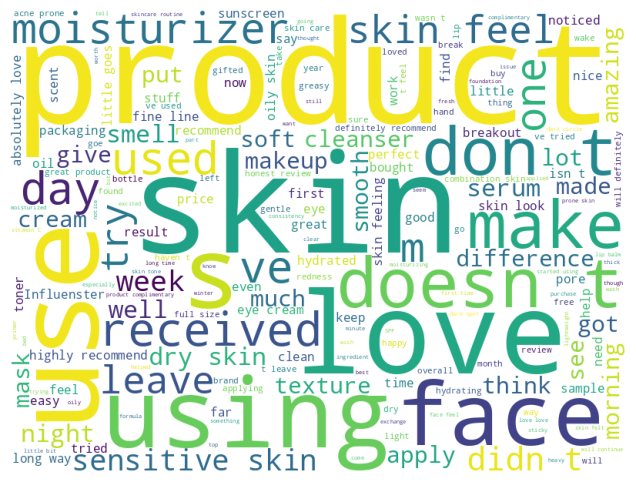

In [12]:
#To create a Wordcloud for positive reviews prior to preprossing techniques.
allposwords = ' '.join(word for word in df_pos['review_text'])
wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color = 'white').generate(allposwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

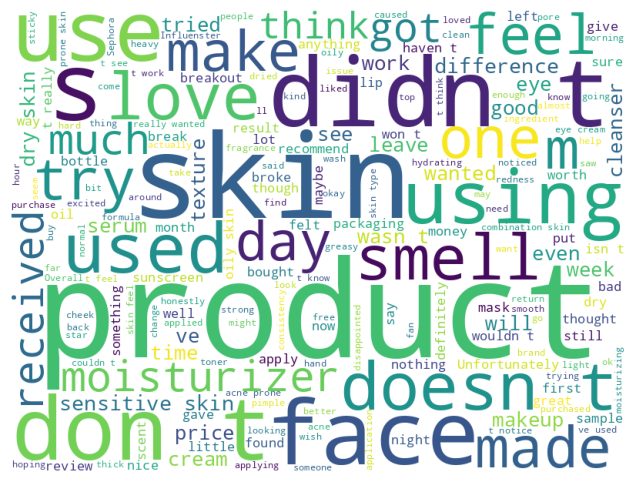

In [13]:
#To create a Wordcloud for negative reviews prior to preprossing techniques.
allnegwords = ' '.join(word for word in df_neg['review_text'])
wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color = 'white').generate(allnegwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
#Top 25 words for positive reviews prior to preprossing techniques.
from collections import Counter
Counter(" ".join(df_pos["review_text"]).split()).most_common(25)

[('I', 2370353),
 ('and', 1964132),
 ('my', 1422990),
 ('the', 1416006),
 ('a', 1387179),
 ('it', 1149763),
 ('this', 1082174),
 ('to', 968410),
 ('is', 841618),
 ('skin', 817313),
 ('for', 635875),
 ('of', 558662),
 ('have', 493331),
 ('in', 473026),
 ('but', 431424),
 ('so', 428521),
 ('on', 410942),
 ('that', 401639),
 ('with', 398815),
 ('product', 375450),
 ('It', 368680),
 ('This', 296999),
 ('use', 287718),
 ('was', 285846),
 ('love', 285827)]

In [15]:
#Top 25 words for negative reviews prior to preprossing techniques.
from collections import Counter
Counter(" ".join(df_neg["review_text"]).split()).most_common(25)

[('I', 540926),
 ('the', 343993),
 ('it', 317828),
 ('and', 317490),
 ('a', 282187),
 ('my', 263264),
 ('to', 250939),
 ('this', 221116),
 ('for', 173525),
 ('but', 149026),
 ('is', 139075),
 ('of', 136081),
 ('skin', 128687),
 ('not', 116870),
 ('was', 106830),
 ('on', 96851),
 ('product', 94839),
 ('have', 91975),
 ('that', 90877),
 ('in', 90411),
 ('like', 81446),
 ('with', 74981),
 ('It', 70835),
 ('so', 69512),
 ('as', 58839)]

In [16]:
#Downsize majority class to length of negative reviews
df_pos2 = combined_file [combined_file['Sentiment'] == 1].sample(len(df_neg))
df_pos2.Sentiment.value_counts()

1    195813
Name: Sentiment, dtype: int64

In [17]:
#Combine positive and negative and shuffle dataframe.
df = pd.concat([df_pos2, df_neg], axis = 0)
df = shuffle(df)
df.head()

,Unnamed: 0,author_id,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price,Sentiment
302653,302653,5263698918,5,1.0,NaN,0,0,0,2018-07-16,I didn’t want to love this as much as I do bec...,...,0,0,"['Good for: Dullness/Uneven Texture', 'Communi...",Skincare,Masks,Face Masks,1,28.0,28.0,1
612521,10391,39435523103,5,1.0,NaN,0,0,0,2022-07-29,This is a great option for an eye cream! It do...,...,0,1,"['Good for: Loss of firmness', 'Good for: Dark...",Skincare,Eye Care,Eye Creams & Treatments,0,NaN,NaN,1
81606,81606,7891654983,5,1.0,1.0,3,0,3,2021-01-17,"I love this cleanser, the first one I’ve used ...",...,0,0,"['Refill Available', 'Community Favorite', 'Go...",Skincare,Mini Size,NaN,0,NaN,NaN,1
953509,94677,1800653420,3,0.0,NaN,0,0,0,2020-03-30,The oil was very thick. I do not think it’s ri...,...,0,0,"['Good for: Dullness/Uneven Texture', 'Good fo...",Skincare,Moisturizers,Face Oils,0,NaN,NaN,0
810539,158432,2292500481,3,0.0,1.0,2,0,2,2020-05-11,The product came packaged beautifully and love...,...,0,0,NaN,Skincare,Lip Balms & Treatments,NaN,0,NaN,NaN,0


In [18]:
#Preprocessing
def preprocess_text(text, remove_digits=True):
    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Removing square brackets
    text = re.sub('\[[^]]*\]', '', text)

    # Removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)

    # Lowercasing
    text = text.lower()

    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    # Removing stopwords
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

#Apply to dataframe
df['review_text'] = df['review_text'].apply(preprocess_text)


In [19]:
#Apply preprossing individually to positive and negative dataframes
df_neg['review_text'] = df_neg['review_text'].apply(preprocess_text)
df_pos['review_text'] = df_pos['review_text'].apply(preprocess_text)

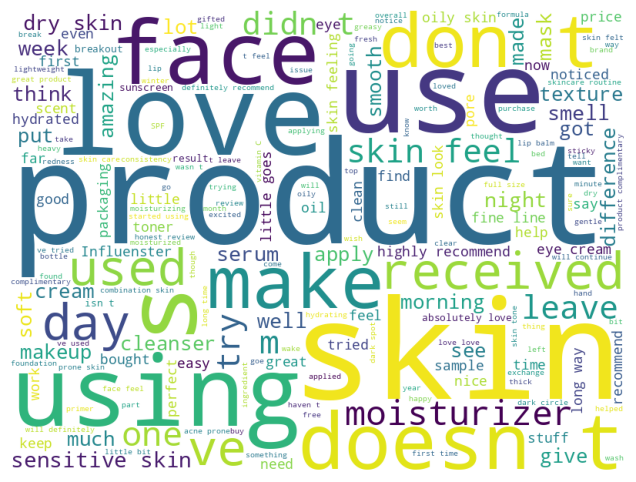

In [20]:
#To create a Wordcloud for positive reviews after the application of preprossing techniques.
allposwords2 = ' '.join(word for word in df_pos['review_text'])

wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color = 'white').generate(allposwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

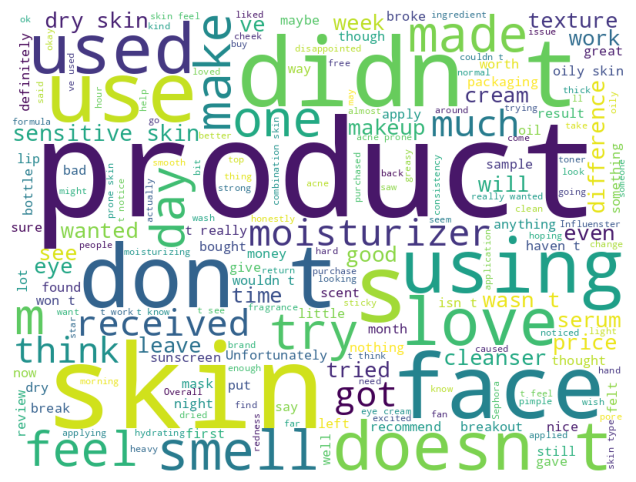

In [21]:
#To create a Wordcloud for negative reviews after the application of preprossing techniques.
allnegwords2 = ' '.join(word for word in df_neg['review_text'])

wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color = 'white').generate(allnegwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
#Top 25 words for positive reviews prior to preprossing techniques
Counter(" ".join(df_pos["review_text"]).split()).most_common(25)

[('thi', 1456859),
 ('skin', 1098772),
 ('use', 743018),
 ('product', 642095),
 ('love', 445670),
 ('feel', 408244),
 ('like', 298071),
 ('wa', 290871),
 ('face', 282241),
 ('moistur', 279652),
 ('realli', 235097),
 ('ha', 228286),
 ('veri', 227133),
 ('dri', 223954),
 ('look', 207517),
 ('tri', 193782),
 ('great', 190878),
 ('ive', 185715),
 ('hydrat', 173950),
 ('make', 172419),
 ('day', 169242),
 ('one', 163156),
 ('im', 157747),
 ('smell', 157544),
 ('cream', 156190)]

In [24]:
#Top 25 words for negative reviews after the application of preprossing techniques.
Counter(" ".join(df_neg["review_text"]).split()).most_common(25)

[('thi', 281789),
 ('skin', 188106),
 ('product', 151397),
 ('use', 139705),
 ('wa', 109322),
 ('like', 92624),
 ('feel', 65097),
 ('face', 62005),
 ('realli', 53772),
 ('dri', 51407),
 ('didnt', 49795),
 ('moistur', 48591),
 ('tri', 48398),
 ('veri', 46430),
 ('would', 45606),
 ('smell', 45556),
 ('dont', 41563),
 ('love', 41159),
 ('work', 37764),
 ('get', 36219),
 ('becaus', 36171),
 ('im', 35227),
 ('good', 32073),
 ('eye', 30437),
 ('look', 29883)]

In [25]:
#Keep rows that are not NA for ingredients
df_neg_ing = df_neg[df_neg['ingredients'].notna()]
df_pos_ing = df_pos[df_pos['ingredients'].notna()]

In [26]:
#Top 25 ingredient words for negative reviews
Counter(" ".join(df_neg_ing["ingredients"]).split()).most_common(25)

[('Extract,', 721223),
 ('Sodium', 389470),
 ('Oil,', 314275),
 ('Acid,', 279904),
 ('Glycol,', 208714),
 ('Seed', 202427),
 ('Leaf', 185891),
 ('Fruit', 175689),
 ('Glycerin,', 138891),
 ('Alcohol,', 127556),
 ('Root', 109679),
 ('Flower', 102585),
 ('Phenoxyethanol,', 95353),
 ('Potassium', 82541),
 ('Gum,', 81009),
 ('Glyceryl', 80931),
 ('Butylene', 80927),
 ('Copolymer,', 76570),
 ('Citrus', 74395),
 ('Hyaluronate,', 70304),
 ('Tocopherol,', 69379),
 ('Propanediol,', 69262),
 ('Stearate,', 68710),
 ('Citric', 68141),
 ('Benzoate,', 68062)]

In [27]:
#Top 25 ingredient words for positive reviews. Both lists appear similar.
Counter(" ".join(df_pos_ing["ingredients"]).split()).most_common(25)

[('Extract,', 3403862),
 ('Sodium', 1840023),
 ('Oil,', 1468743),
 ('Acid,', 1334690),
 ('Glycol,', 968507),
 ('Seed', 932459),
 ('Leaf', 910568),
 ('Fruit', 818830),
 ('Glycerin,', 642404),
 ('Alcohol,', 569627),
 ('Root', 539167),
 ('Flower', 503930),
 ('Phenoxyethanol,', 411559),
 ('Potassium', 404548),
 ('Glyceryl', 400097),
 ('Citrus', 383403),
 ('Butylene', 368013),
 ('Gum,', 356674),
 ('Stearate,', 332343),
 ('Citric', 329325),
 ('Copolymer,', 318377),
 ('Hyaluronate,', 316583),
 ('Tocopherol,', 315619),
 ('Benzoate,', 315472),
 ('Propanediol,', 312173)]

In [70]:
#Top 10 brands with positive reviews.
print(collections.Counter(df_pos['brand_name_x']).most_common(10))



[('CLINIQUE', 39796), ('Tatcha', 37082), ('fresh', 34421), ('Drunk Elephant', 31654), ('The Ordinary', 28328), ('Glow Recipe', 25748), ('Origins', 24579), ('Peter Thomas Roth', 23895), ('Youth To The People', 23201), ('LANEIGE', 22756)]


In [71]:
#Top 10 brands with negative reviews.
print(collections.Counter(df_neg['brand_name_x']).most_common(10))

[('Drunk Elephant', 10655), ('Tatcha', 9605), ('CLINIQUE', 9181), ('The Ordinary', 7481), ('The INKEY List', 6853), ('fresh', 6407), ('Youth To The People', 5918), ('Glow Recipe', 5725), ('Dr. Jart+', 5268), ('Sunday Riley', 5154)]
